In [1]:
import numpy as np
import pandas as pd

%matplotlib inline 
from matplotlib import pyplot as plt # inline outputs plots inline in the console
plt.style.use('ggplot')
import seaborn as sns

wine = pd.read_csv('winequality-red.csv')

In [2]:
wine['quality']=pd.cut(wine.quality,[0,7,10],right=False,labels = ['no','yes'])

In [3]:
wine.quality.value_counts()

no     1382
yes     217
Name: quality, dtype: int64

# EDA / Visualization

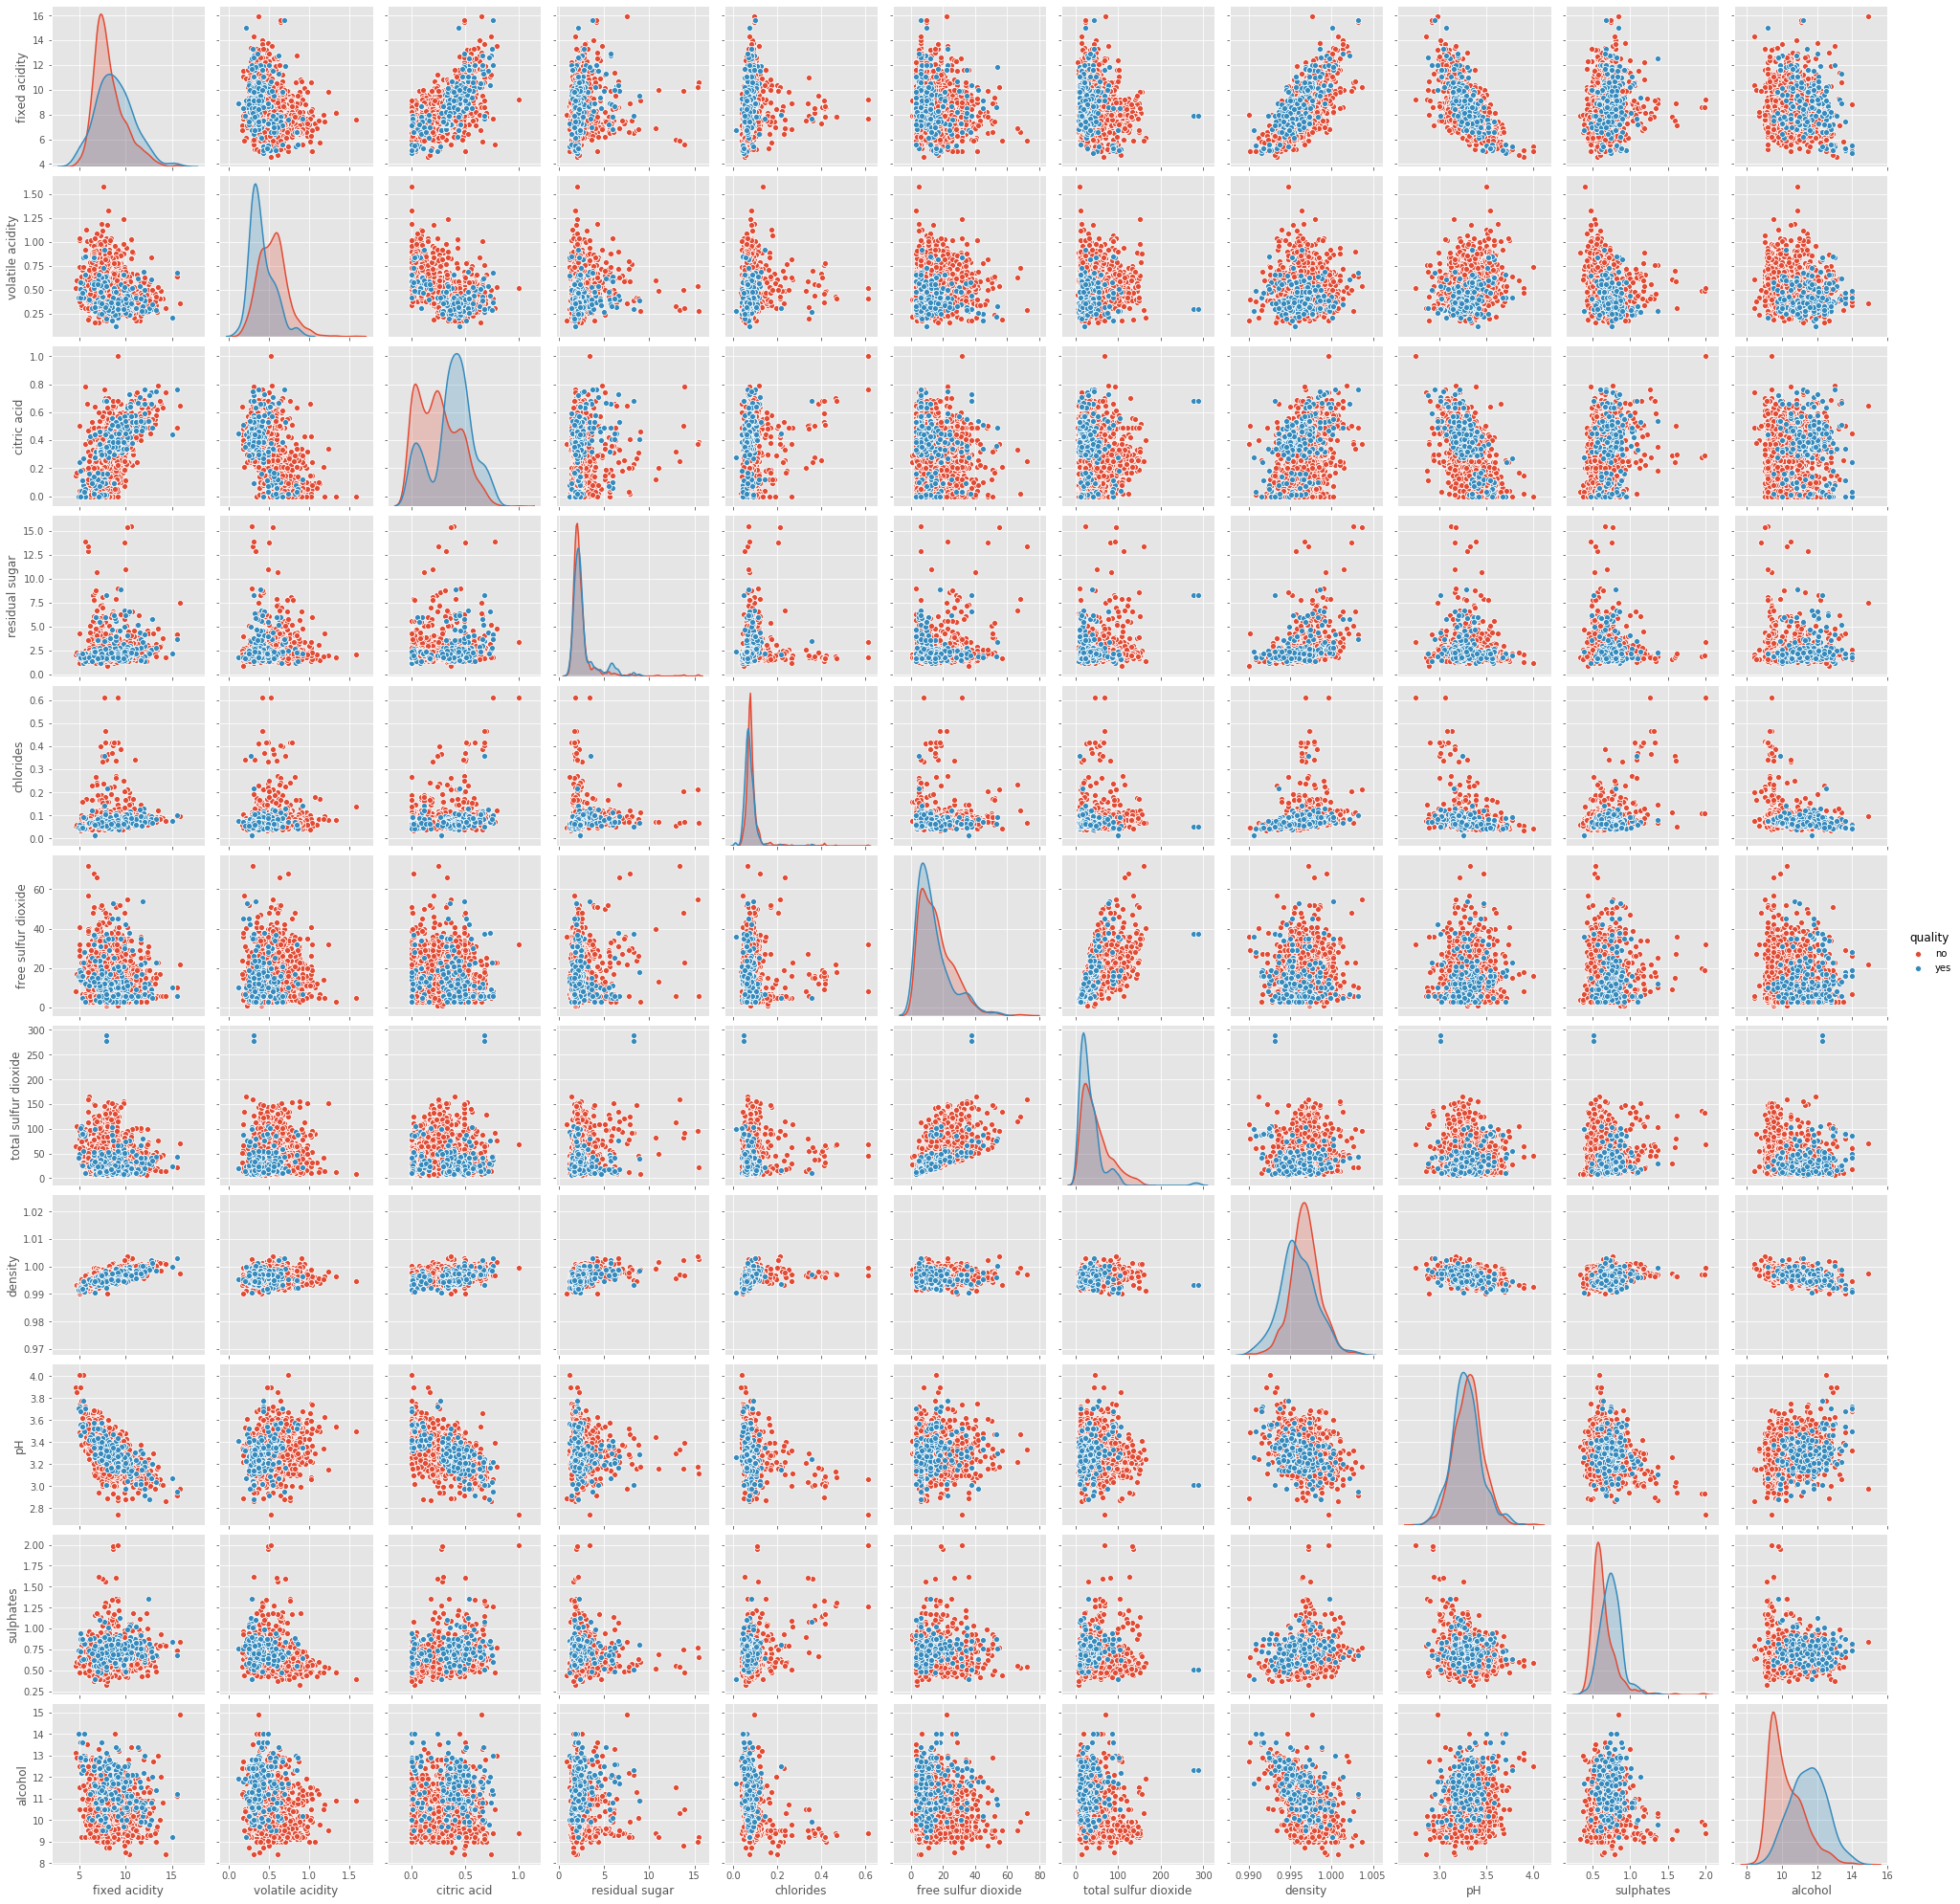

In [4]:
sns.pairplot(wine,hue="quality")

In [ ]:
sns.FacetGrid?

In [5]:
def make_distplot(df,colname,ratio=1):
    fct = sns.FacetGrid(df, hue = 'quality',aspect=ratio)
    return fct.map(sns.distplot, colname, hist=False, kde=True,kde_kws = {'shade': True, 'linewidth': 1.5})

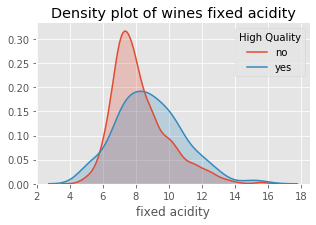

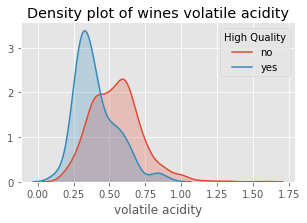

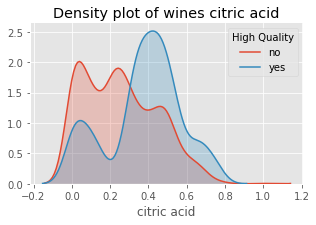

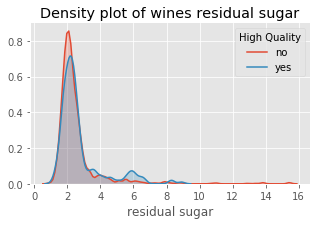

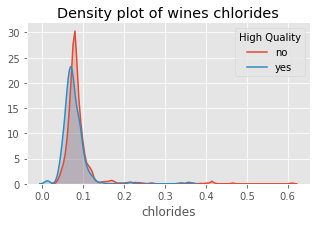

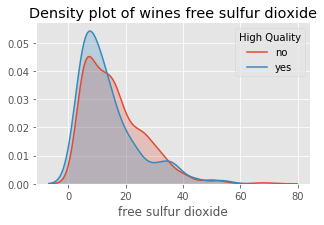

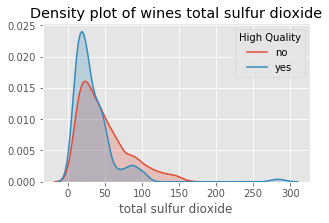

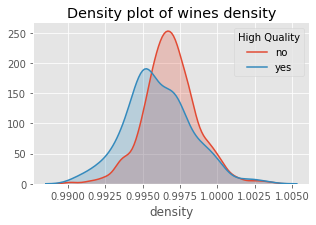

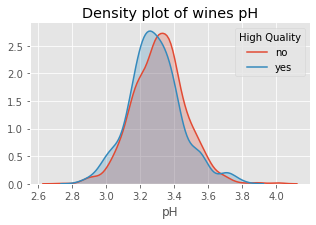

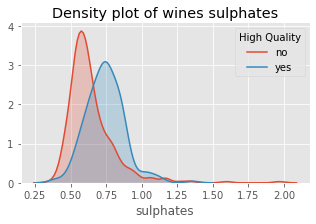

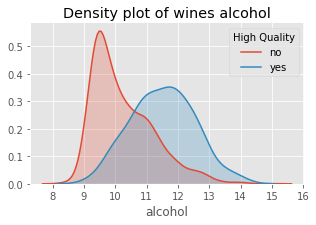

In [6]:
for column in wine.columns[0:11]:
    make_distplot(wine,column,ratio=1.5)
    plt.legend(title="High Quality")
    plt.title(f'Density plot of wines {column}')

<Figure size 864x864 with 0 Axes>

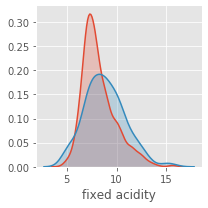

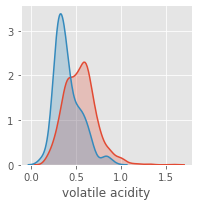

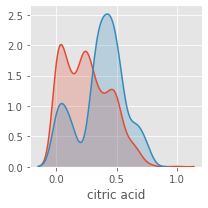

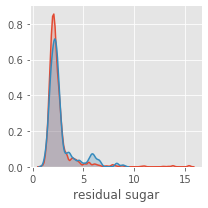

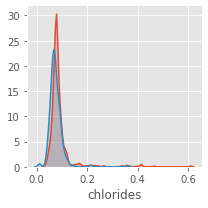

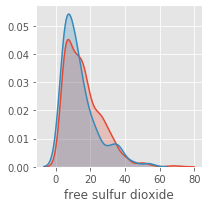

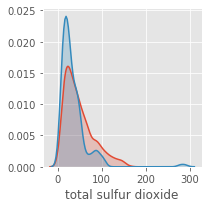

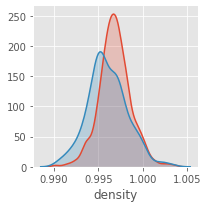

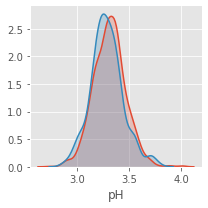

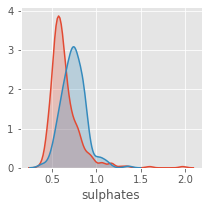

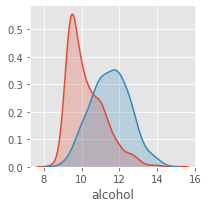

In [7]:
fig = plt.figure(figsize=(12,12))
for index,column in enumerate(list(wine.columns[0:11])):
    make_distplot(wine,column)

# Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
rfc = RandomForestClassifier()

In [27]:
Xtrain,xtest,ytrain,ytest = train_test_split(wine.drop('quality',axis=1),wine['quality'],stratify=wine['quality'])

In [42]:
rfc.set_params(criterion='gini',n_estimators=250,max_features='sqrt',class_weight='balanced')

RandomForestClassifier(max_features='sqrt', n_estimators=250)

In [47]:
params = {'max_depth':[2,3,4],'min_samples_split':[10,25,50,100]}
grid = GridSearchCV(rfc,params,cv=5,verbose=1,return_train_score=True)
grid.fit(Xtrain,ytrain)

results = pd.DataFrame(grid.cv_results_)[['param_max_depth','param_min_samples_split','mean_test_score',
                                          'mean_train_score','rank_test_score']].sort_values('rank_test_score')

grid.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'max_depth': 4, 'min_samples_split': 10}

In [62]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 25,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [65]:
rfc = RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_split=100,class_weight='balanced',
                             n_estimators=250)
rfc.fit(Xtrain,ytrain)

print(f'Training accuracy: {rfc.score(Xtrain,ytrain)}')
print(f'Test accuracy: {rfc.score(xtest,ytest)}')

print(confusion_matrix(ytest,rfc.predict(xtest)))

print(classification_report(ytest,rfc.predict(xtest)))

Training accuracy: 0.8156797331109258
Test accuracy: 0.84
[[288  58]
 [  6  48]]
              precision    recall  f1-score   support

          no       0.98      0.83      0.90       346
         yes       0.45      0.89      0.60        54

    accuracy                           0.84       400
   macro avg       0.72      0.86      0.75       400
weighted avg       0.91      0.84      0.86       400



In [68]:
featimps = pd.DataFrame(zip(Xtrain.columns,rfc.feature_importances_),columns=['feature','importances'])
featimps.sort_values('importances',ascending=False,inplace=True)
featimps.head(5)

,feature,importances
10,alcohol,0.336347
9,sulphates,0.182931
1,volatile acidity,0.134562
2,citric acid,0.093763
6,total sulfur dioxide,0.066657


## Try the model again with only the 5 most important features

In [69]:
rfc2 = RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_split=100,class_weight='balanced',
                             n_estimators=250)

In [70]:
rfc2.fit(Xtrain[featimps.feature[0:5]],ytrain)
print(f'Training accuracy: {rfc2.score(Xtrain[featimps.feature[0:5]],ytrain)}')
print(f'Test accuracy: {rfc2.score(xtest[featimps.feature[0:5]],ytest)}')

print(confusion_matrix(ytest,rfc2.predict(xtest[featimps.feature[0:5]])))

print(classification_report(ytest,rfc2.predict(xtest[featimps.feature[0:5]])))

Training accuracy: 0.8031693077564637
Test accuracy: 0.81
[[278  68]
 [  8  46]]
              precision    recall  f1-score   support

          no       0.97      0.80      0.88       346
         yes       0.40      0.85      0.55        54

    accuracy                           0.81       400
   macro avg       0.69      0.83      0.71       400
weighted avg       0.90      0.81      0.83       400



# K-Nearest Neighbors

In [153]:
knn = KNeighborsClassifier(n_neighbors=5,weights='distance',p=1)
knn.fit(Xtrain,ytrain)
print(f'Training accuracy: {knn.score(Xtrain,ytrain)}')
print(f'Test accuracy: {knn.score(xtest,ytest)}')

Training accuracy: 1.0
Test accuracy: 0.91


In [154]:
print(confusion_matrix(ytest,knn.predict(xtest)))

print(classification_report(ytest,knn.predict(xtest)))

[[337   9]
 [ 27  27]]
              precision    recall  f1-score   support

          no       0.93      0.97      0.95       346
         yes       0.75      0.50      0.60        54

    accuracy                           0.91       400
   macro avg       0.84      0.74      0.77       400
weighted avg       0.90      0.91      0.90       400



## try with scaled data

In [160]:
wine_std = wine.copy()
# standardize the data
for column in wine_std.columns[0:11]:
    col_mean, col_sd = wine_std[column].mean(), wine_std[column].std()
    wine_std[column] = (wine_std[column] - col_mean) / col_sd

In [161]:
sc_Xtrain, sc_Xtest, sc_ytrain, sc_ytest = train_test_split(wine_std.drop('quality',axis=1),wine_std['quality'],
                                                           stratify=wine_std['quality'])

In [172]:
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(sc_Xtrain,sc_ytrain)
print(f'Training accuracy: {knn2.score(sc_Xtrain,sc_ytrain)}')
print(f'Test accuracy: {knn2.score(sc_Xtest,sc_ytest)}')

print(confusion_matrix(sc_ytest,knn2.predict(sc_Xtest)))

print(classification_report(sc_ytest,knn2.predict(sc_Xtest)))

Training accuracy: 0.9074228523769808
Test accuracy: 0.9025
[[332  14]
 [ 25  29]]
              precision    recall  f1-score   support

          no       0.93      0.96      0.94       346
         yes       0.67      0.54      0.60        54

    accuracy                           0.90       400
   macro avg       0.80      0.75      0.77       400
weighted avg       0.90      0.90      0.90       400



In [175]:
knn2 = KNeighborsClassifier(n_neighbors=5,weights='distance')
knn2.fit(sc_Xtrain,sc_ytrain)
print(f'Training accuracy: {knn2.score(sc_Xtrain,sc_ytrain)}')
print(f'Test accuracy: {knn2.score(sc_Xtest,sc_ytest)}')

print(confusion_matrix(sc_ytest,knn2.predict(sc_Xtest)))

print(classification_report(sc_ytest,knn2.predict(sc_Xtest)))

Training accuracy: 1.0
Test accuracy: 0.91
[[330  16]
 [ 20  34]]
              precision    recall  f1-score   support

          no       0.94      0.95      0.95       346
         yes       0.68      0.63      0.65        54

    accuracy                           0.91       400
   macro avg       0.81      0.79      0.80       400
weighted avg       0.91      0.91      0.91       400



# Linear Support Vector Classifier

In [306]:
from sklearn.svm import LinearSVC

# try out of box model
clf = LinearSVC(max_iter=10000)
clf.fit(sc_Xtrain,sc_ytrain)
print(f'Training accuracy: {clf.score(sc_Xtrain,sc_ytrain)}')
print(f'Test accuracy: {clf.score(sc_Xtest,sc_ytest)}')

print(confusion_matrix(sc_ytest,clf.predict(sc_Xtest)))

print(classification_report(sc_ytest,clf.predict(sc_Xtest)))

Training accuracy: 0.8840700583819849
Test accuracy: 0.875
[[337   9]
 [ 41  13]]
              precision    recall  f1-score   support

          no       0.89      0.97      0.93       346
         yes       0.59      0.24      0.34        54

    accuracy                           0.88       400
   macro avg       0.74      0.61      0.64       400
weighted avg       0.85      0.88      0.85       400



In [324]:
# try with subset
subset_Xtrain = sc_Xtrain[['alcohol','sulphates','volatile acidity','total sulfur dioxide']]
subset_Xtest = sc_Xtest[['alcohol','sulphates','volatile acidity','total sulfur dioxide']]
subset_ytrain = sc_ytrain.copy()
subset_ytest = sc_ytest.copy()

In [331]:
svc = LinearSVC(C=0.001,max_iter=100000)
svc.fit(subset_Xtrain,subset_ytrain)
print(f'Training accuracy: {svc.score(subset_Xtrain,subset_ytrain)}')
print(f'Test accuracy: {svc.score(subset_Xtest,subset_ytest)}')

print(confusion_matrix(subset_ytest,svc.predict(subset_Xtest)))

print(classification_report(subset_ytest,svc.predict(subset_Xtest)))

Training accuracy: 0.8698915763135947
Test accuracy: 0.88
[[344   2]
 [ 46   8]]
              precision    recall  f1-score   support

          no       0.88      0.99      0.93       346
         yes       0.80      0.15      0.25        54

    accuracy                           0.88       400
   macro avg       0.84      0.57      0.59       400
weighted avg       0.87      0.88      0.84       400



In [332]:
svc = LinearSVC(C=0.00001,max_iter=100000)
svc.fit(subset_Xtrain,subset_ytrain)
print(f'Training accuracy: {svc.score(subset_Xtrain,subset_ytrain)}')
print(f'Test accuracy: {svc.score(subset_Xtest,subset_ytest)}')

print(confusion_matrix(subset_ytest,svc.predict(subset_Xtest)))

print(classification_report(subset_ytest,svc.predict(subset_Xtest)))

Training accuracy: 0.8807339449541285
Test accuracy: 0.875
[[331  15]
 [ 35  19]]
              precision    recall  f1-score   support

          no       0.90      0.96      0.93       346
         yes       0.56      0.35      0.43        54

    accuracy                           0.88       400
   macro avg       0.73      0.65      0.68       400
weighted avg       0.86      0.88      0.86       400



In [304]:
svc = LinearSVC(C=10,max_iter=1e5)
svc.fit(sc_Xtrain,sc_ytrain)

print(f'Training accuracy: {svc.score(sc_Xtrain,sc_ytrain)}')
print(f'Test accuracy: {svc.score(sc_Xtest,sc_ytest)}')

print(confusion_matrix(sc_ytest,svc.predict(sc_Xtest)))

print(classification_report(sc_ytest,svc.predict(sc_Xtest)))

Training accuracy: 0.8840700583819849
Test accuracy: 0.875
[[337   9]
 [ 41  13]]
              precision    recall  f1-score   support

          no       0.89      0.97      0.93       346
         yes       0.59      0.24      0.34        54

    accuracy                           0.88       400
   macro avg       0.74      0.61      0.64       400
weighted avg       0.85      0.88      0.85       400



In [ ]:
sv

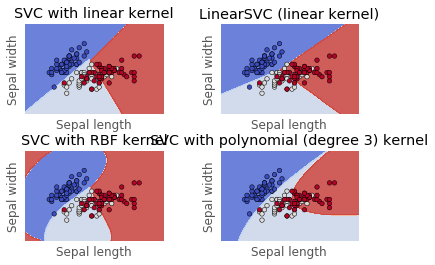

In [303]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()